<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## RNN many-to-one

#### Datos
El objecto es utilizar una serie de sucuencias númericas (datos sintéticos) para poner a prueba el uso de las redes RNN. Este ejemplo se inspiró en otro artículo, lo tienen como referencia en el siguiente link:\
[LINK](https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/)

In [60]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [61]:
# Generar datos sintéticos
X = list()
y = list()

# X será una lista de 1 a 45 agrupado de a 3 números consecutivos
# [ [1, 2, 3], [4, 5, 6], ....]
X = [ [x, x+1, x+2] for x in range(1, 46, 3)]

# "y" (target) se obtiene como la suma de cada grupo de 3 números de entrada
y = [sum(x) for x in X]

X = np.array(X).reshape(len(X), 3, 1)   # (n_samples, seq_len, n_features)
y = np.array(y).reshape(-1, 1)

print("datos X:", X)
print("datos y:", y)

datos X: [[[ 1]
  [ 2]
  [ 3]]

 [[ 4]
  [ 5]
  [ 6]]

 [[ 7]
  [ 8]
  [ 9]]

 [[10]
  [11]
  [12]]

 [[13]
  [14]
  [15]]

 [[16]
  [17]
  [18]]

 [[19]
  [20]
  [21]]

 [[22]
  [23]
  [24]]

 [[25]
  [26]
  [27]]

 [[28]
  [29]
  [30]]

 [[31]
  [32]
  [33]]

 [[34]
  [35]
  [36]]

 [[37]
  [38]
  [39]]

 [[40]
  [41]
  [42]]

 [[43]
  [44]
  [45]]]
datos y: [[  6]
 [ 15]
 [ 24]
 [ 33]
 [ 42]
 [ 51]
 [ 60]
 [ 69]
 [ 78]
 [ 87]
 [ 96]
 [105]
 [114]
 [123]
 [132]]


In [62]:
# Train/valid split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Los pasamos a tensores para poder meterlos a la RRN
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [63]:
y = np.asanyarray(y)
y.shape

(15, 1)

### 2 - Entrenar el modelo

In [64]:
input_shape = X[0].shape
input_shape

(3, 1)

In [65]:
output_shape = 1
output_shape

1

In [66]:
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, bidirectional=False):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]   # última salida de la secuencia
        out = self.relu(out)
        out = self.fc(out)
        return out

In [67]:

def train_model(model, X_train, y_train, X_val, y_val,
                   epochs=5000, batch_size=5, lr=0.001,
                   patience=60, min_delta=1e-4):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {"train_loss": [], "val_loss": []}

    n_samples = X_train.shape[0]
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(n_samples)
        batch_losses = []

        for i in range(0, n_samples, batch_size):
            idx = perm[i:i+batch_size]
            xb, yb = X_train[idx], y_train[idx]

            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        # Validación
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val).item()

        train_loss_mean = np.mean(batch_losses)
        history["train_loss"].append(train_loss_mean)
        history["val_loss"].append(val_loss)


        if (epoch+1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_mean:.4f}, Val Loss: {val_loss:.4f}")


    return history

In [77]:

model1 = RNN()
hist1 = train_model(model1, X_train, y_train, X_val, y_val,epochs=2000)


Epoch [50/2000], Train Loss: 4935.8845, Val Loss: 5441.9038
Epoch [100/2000], Train Loss: 5187.0694, Val Loss: 4974.7212
Epoch [150/2000], Train Loss: 6033.7041, Val Loss: 4564.1733
Epoch [200/2000], Train Loss: 3957.9799, Val Loss: 4194.4351
Epoch [250/2000], Train Loss: 4091.6401, Val Loss: 3868.7341
Epoch [300/2000], Train Loss: 2791.5905, Val Loss: 3572.7957
Epoch [350/2000], Train Loss: 3459.8286, Val Loss: 3216.8816
Epoch [400/2000], Train Loss: 3865.3911, Val Loss: 2880.0798
Epoch [450/2000], Train Loss: 2315.2644, Val Loss: 2602.6819
Epoch [500/2000], Train Loss: 2209.4119, Val Loss: 2357.3948
Epoch [550/2000], Train Loss: 1929.5718, Val Loss: 2131.9553
Epoch [600/2000], Train Loss: 2415.1506, Val Loss: 1926.1705
Epoch [650/2000], Train Loss: 1487.5331, Val Loss: 1741.8624
Epoch [700/2000], Train Loss: 1360.5639, Val Loss: 1567.9000
Epoch [750/2000], Train Loss: 1646.7329, Val Loss: 1409.5405
Epoch [800/2000], Train Loss: 1502.1725, Val Loss: 1261.8080
Epoch [850/2000], Train L

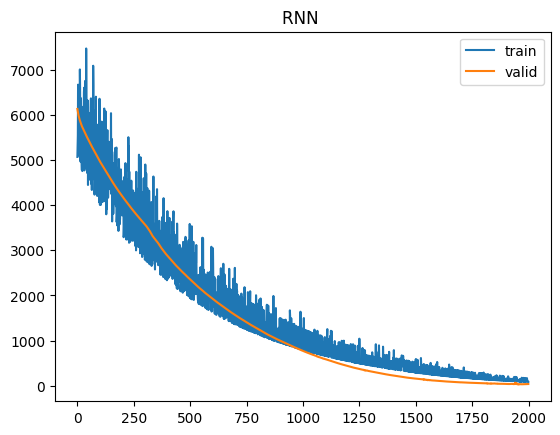

In [78]:
#Curva de entrenamiento
plt.plot(hist1["train_loss"], label="train")
plt.plot(hist1["val_loss"], label="valid")
plt.legend()
plt.title("RNN ")
plt.show()

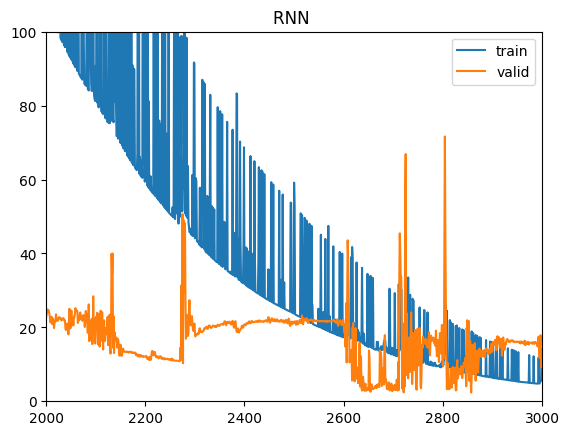

In [74]:
#Curva de entrenamiento
plt.plot(hist1["train_loss"], label="train")
plt.plot(hist1["val_loss"], label="valid")
plt.ylim(0,100)
plt.xlim(2000,3000)
plt.legend()
plt.title("RNN ")
plt.show()

In [79]:

# Ensayo
x_test = np.array([[50, 51, 52]]).reshape((1, 3, 1))
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor([[sum([50, 51, 52])]], dtype=torch.float32)

with torch.no_grad():
    y_hat1 = model1(x_test).item()

print("Modelo Simple y_test:", y_test.item(), "y_hat:", y_hat1)

Modelo Simple y_test: 153.0 y_hat: 103.65801239013672


### 3 - Bidirectional RNN (BRNN)

In [86]:
# En esta oportunidad se utilizará Bidirectional, dentro se especifica
# que lo que se desea hacer bidireccional es una capa LSTM

# En el summary se puede observar que la cantidad de parámetros
# de nuestor nueva capa LSTM bidireccional es el doble que la anterior

model2 = RNN(bidirectional=True)

hist2 = train_model(model2, X_train, y_train, X_val, y_val,epochs=1800)

with torch.no_grad():
    y_hat2 = model2(x_test).item()

print("y_test:", y_test.item())
print("y_hat (bidirectional):", y_hat2)

Epoch [50/1800], Train Loss: 5801.2133, Val Loss: 5246.8286
Epoch [100/1800], Train Loss: 5250.0256, Val Loss: 4499.8408
Epoch [150/1800], Train Loss: 4119.1821, Val Loss: 3883.4084
Epoch [200/1800], Train Loss: 2878.3464, Val Loss: 3363.6113
Epoch [250/1800], Train Loss: 2324.3462, Val Loss: 2839.6873
Epoch [300/1800], Train Loss: 3208.8838, Val Loss: 2385.9126
Epoch [350/1800], Train Loss: 1725.8712, Val Loss: 1999.3036
Epoch [400/1800], Train Loss: 1906.1281, Val Loss: 1676.1127
Epoch [450/1800], Train Loss: 2171.7229, Val Loss: 1401.5562
Epoch [500/1800], Train Loss: 1082.1661, Val Loss: 1152.9406
Epoch [550/1800], Train Loss: 1068.2743, Val Loss: 943.5546
Epoch [600/1800], Train Loss: 923.0562, Val Loss: 774.7559
Epoch [650/1800], Train Loss: 793.9506, Val Loss: 618.5490
Epoch [700/1800], Train Loss: 985.8749, Val Loss: 490.3255
Epoch [750/1800], Train Loss: 524.3048, Val Loss: 380.0852
Epoch [800/1800], Train Loss: 803.7256, Val Loss: 297.0739
Epoch [850/1800], Train Loss: 397.51

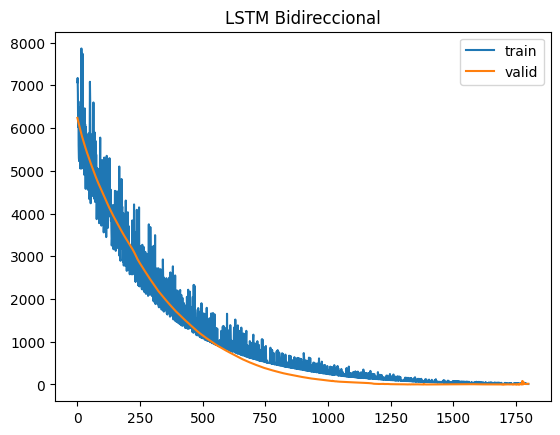

In [87]:
plt.plot(hist2["train_loss"], label="train")
plt.plot(hist2["val_loss"], label="valid")
plt.legend()
plt.title("LSTM Bidireccional")
plt.show()

In [88]:
# Ensayo
x_test = np.array([[50, 51, 52]]).reshape((1, 3, 1))
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor([[sum([50, 51, 52])]], dtype=torch.float32)

with torch.no_grad():
    y_hat2 = model2(x_test).item()

print("Modelo Bidireccional y_test:", y_test.item(), "y_hat:", y_hat2)

Modelo Bidireccional y_test: 153.0 y_hat: 119.81555938720703


### 4 - Conclusión
Implementar un modelo bidireccional basado en RNN es muy sencillo. Más allá de que esta tarea podria resolverse de otras maneras, les queda nota de como definir y entrenar estos tipos de redes neuronales recurrentes con y sin bidireccionalidad.